# Build a model with the augmented and balanced data

<p>In this notebook, the augmented and balanced data is used to build models using four different classifiers:</p>
<ul>
    <li>MLP Classifier</li>
    <li>Random Forest</li>
    <li>Linear SVC</li>
    <li>Logistic Regression</li>
</ul>
<p>The champion model is the MLP Classifier.</p>

In [80]:
# Import libraries
import pandas as pd
import numpy as np
import json
import pickle
import spacy
from spacy.matcher import DependencyMatcher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_lg')
matcher = DependencyMatcher(nlp.vocab)

In [3]:
# Open the pattern JSON file
with open("../data/patterns.json", "r") as file:
    patterns_dict = json.load(file)

# Add the patterns to the matcher
for pattern_name, pattern_list in patterns_dict.items():
    matcher.add(f'{pattern_name}', [pattern_list])

In [4]:
df = pd.read_csv('../data/PELIC_ASAG_balanced.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
df.head()

,level,L1,question_type,question,answer,dataset,is_augmented
0,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",Can you give me a opinion about this matter?,PELIC,0
1,2,Chinese,Short answer,"Write a sentence with the word ""own"".",I own this car and this horse.,PELIC,0
2,2,Italian,Short answer,"Write a sentence with the word ""own"".",I own a car.,PELIC,0
3,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",I don't have opinion about that thing,PELIC,0
4,2,Korean,Short answer,"Write a sentence with the word ""opinion"".",The opinion is my ider. \n\nSometimes i think ...,PELIC,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   level          6999 non-null   int64 
 1   L1             6999 non-null   object
 2   question_type  6999 non-null   object
 3   question       6999 non-null   object
 4   answer         6999 non-null   object
 5   dataset        6999 non-null   object
 6   is_augmented   6999 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 382.9+ KB


In [7]:
df.level.value_counts()

level
3    1754
4    1754
5    1754
2    1737
Name: count, dtype: int64

In [19]:
# Define functions to extract features
def count_patterns(text, matcher):
    """Count the number of pattern matches in the text."""
    # convert text to nlp doc
    doc = nlp(text)
    # store the matches
    matches = matcher(doc)
    # count the matches
    # count matches in respective columns
    counts = {pattern_name: 0 for pattern_name in patterns_dict.keys()}
    for match_id, token_ids in matches:
        pattern_name = matcher.vocab.strings[match_id]
        counts[pattern_name] += 1
    return counts

def find_patterns(df):
    df = df.copy()
    pattern_names = list(patterns_dict.keys())
    
    # Initialize columns for pattern counts as floats
    for pattern_name in pattern_names:
        df[pattern_name] = 0.0
    
    df['num_sentences'] = 0
    df['avg_sentence_len'] = 0.0
    df['doc_vector'] = None
    
    for index, row in df.iterrows():
        answer_text = row['answer']
        doc = nlp(answer_text)
        total_tokens = 0
        num_sentences = 0

        # First, count the sentences and calculate average sentence length
        for sentence in doc.sents:
            num_tokens = len(sentence)
            total_tokens += num_tokens
            num_sentences += 1

        avg_sentence_len = total_tokens / num_sentences if num_sentences > 0 else 0
        df.loc[index, 'num_sentences'] = num_sentences
        df.loc[index, 'avg_sentence_len'] = avg_sentence_len

        # Count patterns in the original text
        pattern_counts = count_patterns(answer_text, matcher)
        for pattern_name, count in pattern_counts.items():
            df.at[index, pattern_name] = count

        # Vectorize the text
        df.at[index, 'doc_vector'] = doc.vector
    
    return df

In [20]:
# Run the function on a small sample of the data to make sure it's working well
sample_df = df.head(20)
sample_df = find_patterns(sample_df)
sample_df.head()

,level,L1,question_type,question,answer,dataset,is_augmented,present_simple_active,present_simple_active_aux,present_simple_active_modal,...,past_perfect_continuous_active,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp,num_sentences,avg_sentence_len,doc_vector
0,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",Can you give me a opinion about this matter?,PELIC,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10.0,"[0.0011769056, 2.9805837, -5.421795, -1.281726..."
1,2,Chinese,Short answer,"Write a sentence with the word ""own"".",I own this car and this horse.,PELIC,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.0,"[0.6177107, -0.139415, -5.1839, -3.4223375, 2...."
2,2,Italian,Short answer,"Write a sentence with the word ""own"".",I own a car.,PELIC,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5.0,"[-1.2149088, 0.9414881, -6.9475403, -3.24902, ..."
3,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",I don't have opinion about that thing,PELIC,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.0,"[-0.66809255, 4.0117087, -4.705406, -2.6067538..."
4,2,Korean,Short answer,"Write a sentence with the word ""opinion"".",The opinion is my ider. \n\nSometimes i think ...,PELIC,0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.0,"[0.741248, 0.15120213, -2.5288677, -2.9930537,..."


In [21]:
df = find_patterns(df)

In [22]:
# Save the DataFrame to a pickle file because it takes long to run, and a csv changes the vectors to strings
with open('../data/PELIC_ASAG_balanced_matched_vectors.pkl', 'wb') as file:
    pickle.dump(df, file)

In [87]:
# Load the DataFrame from a pickle file
with open('../data/PELIC_ASAG_balanced_matched_vectors.pkl', 'rb') as file:
    df = pickle.load(file)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 41 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   level                                     6999 non-null   int64  
 1   L1                                        6999 non-null   object 
 2   question_type                             6999 non-null   object 
 3   question                                  6999 non-null   object 
 4   answer                                    6999 non-null   object 
 5   dataset                                   6999 non-null   object 
 6   is_augmented                              6999 non-null   int64  
 7   present_simple_active                     6999 non-null   float64
 8   present_simple_active_aux                 6999 non-null   float64
 9   present_simple_active_modal               6999 non-null   float64
 10  present_simple_passive              

In [89]:
df.head()

,level,L1,question_type,question,answer,dataset,is_augmented,present_simple_active,present_simple_active_aux,present_simple_active_modal,...,past_perfect_continuous_active,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp,num_sentences,avg_sentence_len,doc_vector
0,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",Can you give me a opinion about this matter?,PELIC,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10.0,"[0.0011769056, 2.9805837, -5.421795, -1.281726..."
1,2,Chinese,Short answer,"Write a sentence with the word ""own"".",I own this car and this horse.,PELIC,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.0,"[0.6177107, -0.139415, -5.1839, -3.4223375, 2...."
2,2,Italian,Short answer,"Write a sentence with the word ""own"".",I own a car.,PELIC,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5.0,"[-1.2149088, 0.9414881, -6.9475403, -3.24902, ..."
3,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",I don't have opinion about that thing,PELIC,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.0,"[-0.66809255, 4.0117087, -4.705406, -2.6067538..."
4,2,Korean,Short answer,"Write a sentence with the word ""opinion"".",The opinion is my ider. \n\nSometimes i think ...,PELIC,0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.0,"[0.741248, 0.15120213, -2.5288677, -2.9930537,..."


In [90]:
# Look at the columns and select which ones to use in X
df.columns

Index(['level', 'L1', 'question_type', 'question', 'answer', 'dataset',
       'is_augmented', 'present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would

In [91]:
# Define a df for the average sentence length
df_avg_sentence_len = df['avg_sentence_len']

In [92]:
# Create a df of verb tense counts and square the counts so that they're more detectable in the model
verbs_df = df[['present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would', 'gerund_subject', 'gerund_pcomp', 'gerund_xcomp']] **2
verbs_df.head()
verbs_df = verbs_df.reset_index(drop=True)

In [93]:
# Put each element from the doc vector into a column in a new df
vectors_df = pd.DataFrame(df['doc_vector'].values.tolist(), columns=[f'doc_vector_{i}' for i in range(300)])
# Reset the index to ensure clean concatenation
vectors_df = vectors_df.reset_index(drop=True)
vectors_df.head()

,doc_vector_0,doc_vector_1,doc_vector_2,doc_vector_3,doc_vector_4,doc_vector_5,doc_vector_6,doc_vector_7,doc_vector_8,doc_vector_9,...,doc_vector_290,doc_vector_291,doc_vector_292,doc_vector_293,doc_vector_294,doc_vector_295,doc_vector_296,doc_vector_297,doc_vector_298,doc_vector_299
0,0.001177,2.980584,-5.421795,-1.281727,-0.449789,-0.875335,0.627154,2.420096,-3.049300,1.934144,...,1.296048,-0.760914,2.950990,-2.118291,-0.661951,-1.646347,0.480740,2.247485,-4.464150,0.876439
1,0.617711,-0.139415,-5.183900,-3.422338,2.627902,1.081989,0.555081,4.305025,-2.196133,2.873312,...,0.055934,0.140013,0.813995,-0.290122,-2.634672,-0.131915,0.169701,0.297600,-5.660123,1.795130
2,-1.214909,0.941488,-6.947540,-3.249020,2.432502,0.090080,0.065674,5.333060,-0.719144,4.390460,...,-2.037826,-0.542940,0.121700,0.196364,-2.728384,0.900282,0.531380,2.123040,-6.227718,2.843520
3,-0.668093,4.011709,-4.705406,-2.606754,-3.828740,1.176264,2.825432,5.347236,-5.579912,2.639131,...,4.311654,-0.151310,2.569969,-2.625725,-3.296537,-2.305901,2.190700,2.120703,-4.476295,2.594638
4,0.741248,0.151202,-2.528868,-2.993054,1.801479,0.272498,0.290326,4.583579,-2.058239,1.491737,...,1.139312,-0.292755,2.777838,-2.276629,-1.133021,0.597654,-0.532742,0.027393,-6.175860,0.389648


In [94]:
# Concatenate the dataframes
df_concat = pd.concat([df_avg_sentence_len, verbs_df, vectors_df], axis=1)
# Check for nulls after the concatentation
print(f"Null values in df_concat: {df_concat.isnull().sum().sum()}")
print(f"Shape of df_concat: {df_concat.shape}")

Null values in df_concat: 0
Shape of df_concat: (6999, 332)


## Split and Scale

In [95]:
X = df_concat
y = df['level']

In [96]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [97]:
# Normalize the data
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

## MLP Classifier

In [108]:
# Initialize and train the classifier
mlp = MLPClassifier(max_iter=2000)
mlp.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_normalized)

Overall Accuracy: 0.7491428571428571
              precision    recall  f1-score   support

           2       0.83      0.82      0.83       434
           3       0.76      0.76      0.76       438
           4       0.71      0.71      0.71       439
           5       0.69      0.71      0.70       439

    accuracy                           0.75      1750
   macro avg       0.75      0.75      0.75      1750
weighted avg       0.75      0.75      0.75      1750

Confusion Matrix:
[[354  28  19  33]
 [ 28 335  35  40]
 [ 25  36 311  67]
 [ 17  40  71 311]]


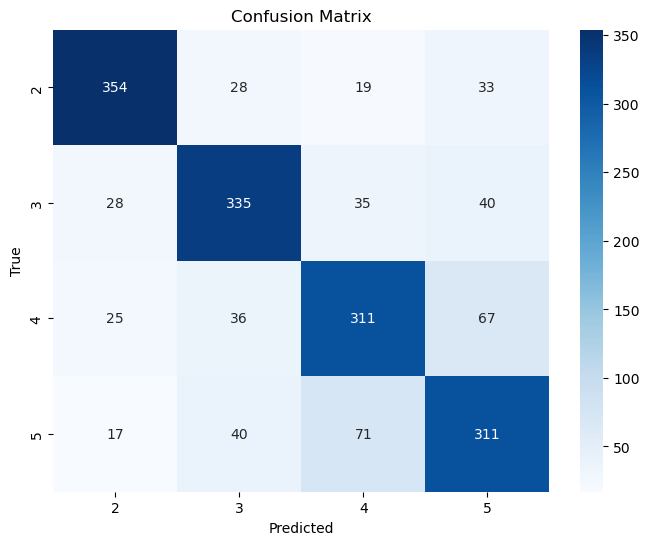

In [109]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [110]:
# Save the trained model to a pickle file
with open('../artifacts/mlp_balanced.pkl', 'wb') as file:
    pickle.dump(mlp, file)

## Random Forest

In [102]:
# Initialize and train the classifier
rf = RandomForestClassifier()
rf.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_normalized)

Overall Accuracy: 0.7308571428571429
              precision    recall  f1-score   support

           2       0.66      0.88      0.76       434
           3       0.91      0.64      0.76       438
           4       0.74      0.69      0.71       439
           5       0.69      0.71      0.70       439

    accuracy                           0.73      1750
   macro avg       0.75      0.73      0.73      1750
weighted avg       0.75      0.73      0.73      1750

Confusion Matrix:
[[384   7   9  34]
 [ 72 282  37  47]
 [ 66  12 301  60]
 [ 61   8  58 312]]


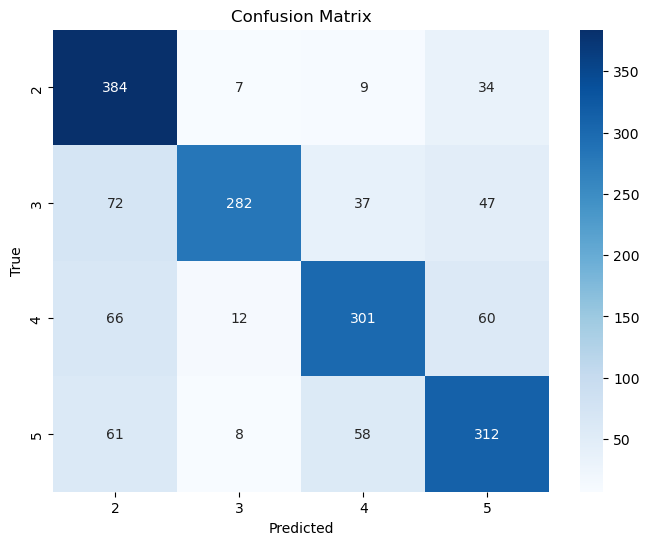

In [103]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Linear SVC

In [100]:
# Initialize and train the classifier
svc = LinearSVC(dual=True)
svc.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = svc.predict(X_test_normalized)

Overall Accuracy: 0.6108571428571429
              precision    recall  f1-score   support

           2       0.72      0.86      0.78       434
           3       0.51      0.70      0.59       438
           4       0.52      0.17      0.25       439
           5       0.65      0.72      0.68       439

    accuracy                           0.61      1750
   macro avg       0.60      0.61      0.58      1750
weighted avg       0.60      0.61      0.58      1750

Confusion Matrix:
[[372  21  15  26]
 [ 58 308  17  55]
 [ 42 236  74  87]
 [ 46  42  36 315]]


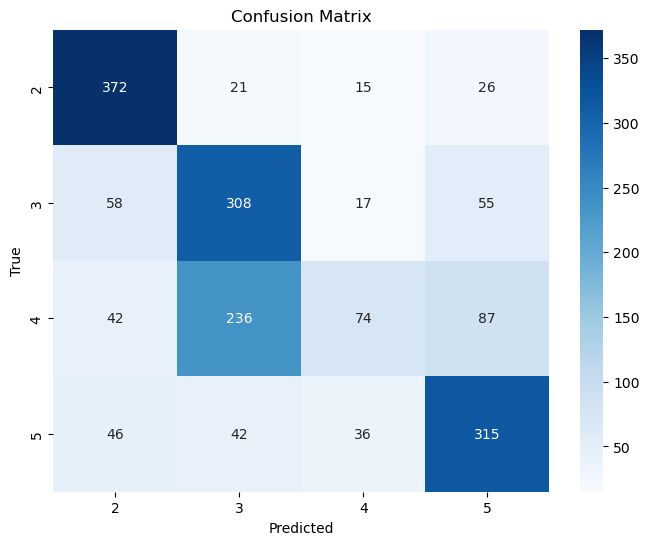

In [101]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc.classes_, yticklabels=svc.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression

In [98]:
# Initialize and train the classifier
log_reg = LogisticRegression()
log_reg.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_normalized)

Overall Accuracy: 0.5091428571428571
              precision    recall  f1-score   support

           2       0.68      0.80      0.74       434
           3       0.40      0.67      0.50       438
           4       0.57      0.17      0.26       439
           5       0.47      0.40      0.43       439

    accuracy                           0.51      1750
   macro avg       0.53      0.51      0.48      1750
weighted avg       0.53      0.51      0.48      1750

Confusion Matrix:
[[348  36  13  37]
 [ 61 295  17  65]
 [ 51 223  74  91]
 [ 50 189  26 174]]


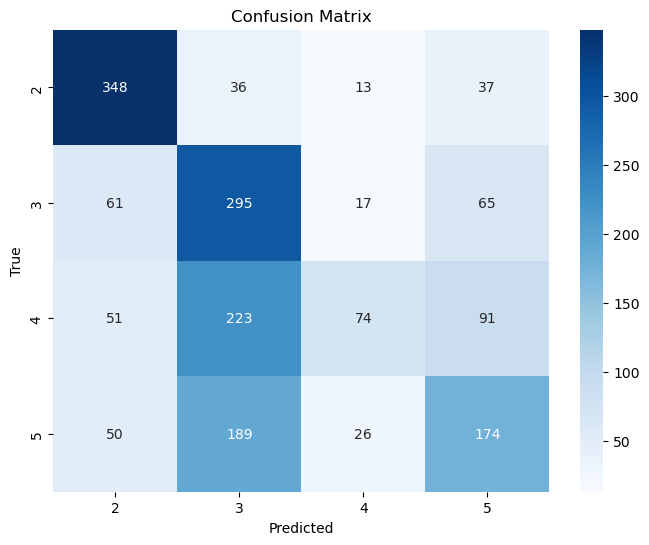

In [99]:
# Calculate overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()